In [ ]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow requests joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib  # Ensure joblib is imported here

# Function to fetch data from OpenAQ
def fetch_openaq_data(city, parameter, date_from, date_to):
    base_url = "https://api.openaq.org/v2/measurements"
    params = {
        "city": city,
        "parameter": parameter,
        "date_from": date_from,
        "date_to": date_to,
        "limit": 10000,
        "order_by": "datetime"
    }

    all_data = []
    while True:
        response = requests.get(base_url, params=params)
        if response.status_code != 200:
            print(f"Error fetching data: {response.status_code}")
            return None

        data = response.json()
        results = data.get('results', [])
        if not results:
            break

        all_data.extend(results)
        if len(results) < 10000:
            break

        # Update date_from for the next request
        last_date = results[-1]['date']['utc']
        params['date_from'] = last_date

    return pd.DataFrame(all_data)

# User input for city name
city_name = input("Enter the city name for air quality prediction: ")

# Fetch last 365 days of PM2.5 data for the entered city
end_date = datetime.now()
start_date = end_date - timedelta(days=365)
df = fetch_openaq_data(city_name, 'pm25', start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))

if df is not None and not df.empty:
    print("Data fetched successfully. Shape:", df.shape)

    # Process the data
    df['date'] = pd.to_datetime(df['date'].apply(lambda x: x['utc']))
    df['value'] = df['value']
    df = df.sort_values('date')
    df = df.set_index('date')
    df = df['value'].resample('H').mean().interpolate()

    print("Processed data shape:", df.shape)

    # Create sequences for LSTM input
    def create_sequences(data, seq_length):
        sequences = []
        targets = []
        for i in range(len(data) - seq_length):
            seq = data[i:i+seq_length]
            target = data[i+seq_length]
            sequences.append(seq)
            targets.append(target)
        return np.array(sequences), np.array(targets)

    seq_length = 24
    X, y = create_sequences(df.values, seq_length)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)
    y_train_scaled = scaler.transform(y_train.reshape(-1, 1))
    y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

    # Save the scaler for future use
    joblib.dump(scaler, 'scaler.pkl')

    print("Data preparation completed.")
    print("Shape of training data (X_train_scaled):", X_train_scaled.shape)
    print("Shape of training labels (y_train_scaled):", y_train_scaled.shape)
    print("Shape of test data (X_test_scaled):", X_test_scaled.shape)
    print("Shape of test labels (y_test_scaled):", y_test_scaled.shape)
else:
    print(f"Failed to fetch data or no data available for {city_name}.")


Enter the city name for air quality prediction: London
Data fetched successfully. Shape: (34007, 13)
Processed data shape: (8759,)
Data preparation completed.
Shape of training data (X_train_scaled): (6988, 24)
Shape of training labels (y_train_scaled): (6988, 1)
Shape of test data (X_test_scaled): (1747, 24)
Shape of test labels (y_test_scaled): (1747, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Ensure input data is in the correct shape (samples, timesteps, features)
if len(X_train_scaled.shape) == 2:
    X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

print("After reshaping:")
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

# Define the model architecture
def create_model(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    return model

input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
model = create_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Print model summary
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")


After reshaping:
X_train_scaled shape: (6988, 24, 1)
X_test_scaled shape: (1747, 24, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - loss: 0.0135 - mae: 0.0782 - val_loss: 0.0013 - val_mae: 0.0246
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0013 - mae: 0.0248 - val_loss: 7.5501e-04 - val_mae: 0.0188
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0010 - mae: 0.0217 - val_loss: 5.9996e-04 - val_mae: 0.0173
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 8.8528e-04 - mae: 0.0197 - val_loss: 6.1126e-04 - val_mae: 0.0170
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.0222e-04 - mae: 0.0182 - val_loss: 7.7412e-04 - val_mae: 0.0203
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.8058e-04 - mae: 0.0179 - val_loss: 7.0679e-04 - val_mae: 0.0192
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6.2102e-04 - mae: 0.0171 - val_loss: 5.9380e-04 - val_mae: 0.0162
Epoch 8/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.8210e-04 - mae: 0.0172 - val_loss: 5.4538e-04 - val_mae: 0.015

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step


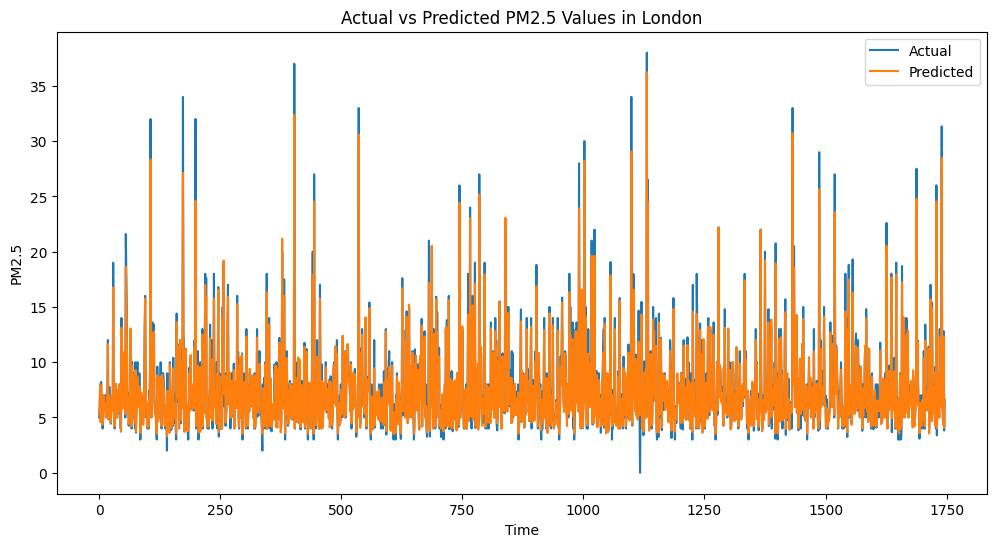

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
Predicted PM2.5 for the next hour in London: 6.90
Model saved as 'air_quality_model.keras'


In [ ]:
# Make predictions
predictions_scaled = model.predict(X_test_scaled)
predictions = scaler.inverse_transform(predictions_scaled)
y_test = scaler.inverse_transform(y_test_scaled)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title(f'Actual vs Predicted PM2.5 Values in {city_name}')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

# Function for making real-time predictions
def predict_next_hour(model, recent_data, scaler):
    recent_data_scaled = scaler.transform(recent_data.reshape(-1, 1)).reshape(1, 24, 1)
    prediction_scaled = model.predict(recent_data_scaled)
    prediction = scaler.inverse_transform(prediction_scaled)
    return prediction[0][0]

# Example of making a prediction for the next hour
last_24_hours = df.values[-24:].reshape(1, -1, 1)
next_hour_prediction = predict_next_hour(model, last_24_hours, scaler)
print(f"Predicted PM2.5 for the next hour in {city_name}: {next_hour_prediction:.2f}")

# Save the model
model.save('air_quality_model.keras')
print("Model saved as 'air_quality_model.keras'")
